In [20]:
import pandas as pd
from get_milestones import main
from path import Path
import os
import time
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('./data/change_org_petitions_Amber_Heard_at_20211005-222550_limit_1000_offset_0_delay_ms_500.csv')

In [ ]:
error_slugs = set()
for slug in tqdm(df['petition__slug']):
    if not isinstance(slug, str):
        continue
    args = type('obj', (object,), {'petition_slug': slug, 'delay_ms': 100})
    with Path('./data'):
        try:
            main(args)
        except Exception as e:
            print(slug, e)
            error_slugs.add(slug)

In [9]:
# first two are not relevant
# the second one does not have public milestones
error_slugs

{'donald-j-trump-free-rapper-ynw-melly-he-is-being-framed-by-police-facing-the-death-penalty-we-have-got-to-stop-the-state-of-florida-from-killing-2-innocent-men-blacklivesmatter-alllivesmatter-freeynwmelly-freeynwbortlen',
 'sheriff-tom-bosenko-california-state-governor-california-state-senate-u-s-attorney-generl-kamala-sheriff-tom-bosenko-california-state-governor-california-state-senate-u-s-attorney-general-k-request-the-fbi-investigate-the-disappearance-of-e',
 'warner-brothers-get-johnny-depp-his-role-in-fantastic-beasts-back-arrest-fire-amber-heard-from-aquaman-2'}

In [10]:
# merging everything into a single dataframe

In [14]:
l = os.listdir('./data')
fs = []
for filename in l:
    if not(filename.startswith('change_org_milestones_petition_slug_') and filename.endswith('.csv')):
        continue
    fs.append('./data/' + filename)

In [64]:
def read_set_slug(f):
    df = pd.read_csv(f)
    slug = os.path.basename(f)[len('change_org_milestones_petition_slug_'):f.index('_at_') + 1]
    df['petition__slug'] = [slug] * len(df)
    return df

In [65]:
df = pd.concat([read_set_slug(f) for f in tqdm(fs)])
df = df.reset_index()

  0%|          | 0/286 [00:00<?, ?it/s]

In [66]:
df.to_csv(f"./data/all_petitions_milestones_{time.strftime('%Y%m%d-%H%M%S')}.csv", index=False)

# Optional: plotting all timelines

In [52]:
from matplotlib import pyplot as plt

In [53]:
df_ = df[df['__typename'] == 'MilestonePetitionUpdate'].copy()

In [54]:
df_['createdAt'] = pd.to_datetime(df_.createdAt)

  0%|          | 0/284 [00:00<?, ?it/s]

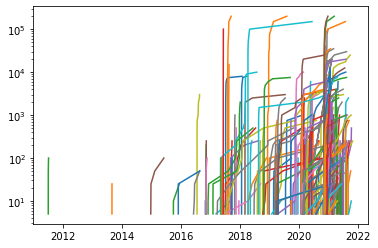

In [57]:
for petition__slug, group in tqdm(df_.groupby('petition__slug')):
    plt.plot(group.createdAt, group.signatureCount, label=petition__slug)
plt.yscale('log')
plt.show()

In [67]:
len(df_)

2407